In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,cleaned_review_stemmed,num_words,has_spoiler,has_plot twist
0,0,2013-07-16,tt0111161,ur34426359,True,Wow! what a film this baby is and yes this fil...,10,Great films come only once in a blue moon,wow film baby ye film one brilliant film ever ...,137,False,False
1,1,2013-07-02,tt0111161,ur30748387,True,"In 1947, banker Andy Dufresne (Tim Robbins) is...",10,Yes...,banker robbin murdering wife lover based circu...,697,False,False
2,2,2015-02-09,tt0111161,ur58506458,True,The Shawshank Redemption is a movie that creat...,10,The Best Movie of all Time,redemption movie create sense mystery power ro...,169,False,False
3,3,2013-04-28,tt0111161,ur22620730,True,And I truly mean that. When I first saw this f...,10,One of the Greatest Films of All Time.,truly mean first saw film blown away superb ac...,286,False,False
4,4,2013-02-15,tt0111161,ur23833870,True,Well let me start off by saying I felt compell...,10,My favourite move of all time,well let start saying felt write review spite ...,249,False,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192994 entries, 0 to 45479
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_date             192994 non-null  object
 1   movie_id                192994 non-null  object
 2   user_id                 192994 non-null  object
 3   is_spoiler              192994 non-null  bool  
 4   review_text             192994 non-null  object
 5   rating                  192994 non-null  int64 
 6   review_summary          192994 non-null  object
 7   cleaned_review_stemmed  192992 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 12.0+ MB


<Axes: title={'center': 'Number of positive and negative samples in the dataset'}, xlabel='is_spoiler'>

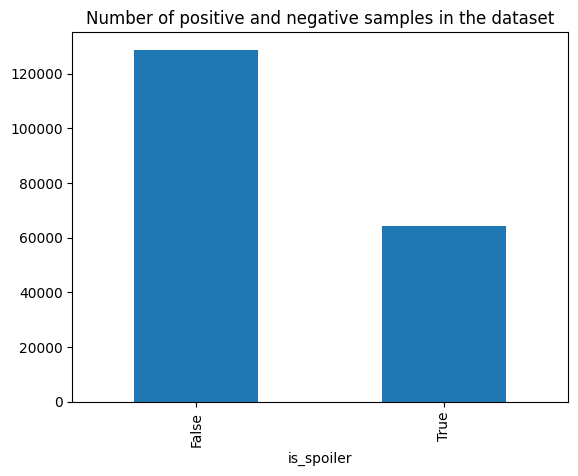

In [ ]:
#Print distribution of output class (is_spoiler), which has two values, True and False
fig = plt.figure()
plt.title("Number of positive and negative samples in the dataset")
df['is_spoiler'].value_counts().plot(kind='bar')

<Axes: title={'center': 'Number of reviews by ratings'}, xlabel='rating'>

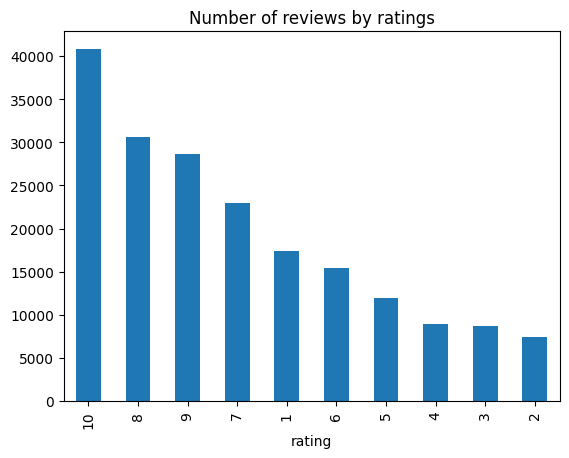

In [ ]:
#Number of reviews grouped by the rating given by the user.
plt.title("Number of reviews by ratings")
df['rating'].value_counts().plot(kind='bar')

In [ ]:
#We can calculate statistics such as the average number of words per review,
#average ratings for movies, and group them by the output class to see if there is any relation between the two.

df['num_words'] = df['review_text'].apply(lambda x : len(x.split(" ")))
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,cleaned_review_stemmed,num_words
0,2013-07-16,tt0111161,ur34426359,True,Wow! what a film this baby is and yes this fil...,10,Great films come only once in a blue moon,wow film baby ye film one brilliant film ever ...,137
1,2013-07-02,tt0111161,ur30748387,True,"In 1947, banker Andy Dufresne (Tim Robbins) is...",10,Yes...,banker robbin murdering wife lover based circu...,697
2,2015-02-09,tt0111161,ur58506458,True,The Shawshank Redemption is a movie that creat...,10,The Best Movie of all Time,redemption movie create sense mystery power ro...,169
3,2013-04-28,tt0111161,ur22620730,True,And I truly mean that. When I first saw this f...,10,One of the Greatest Films of All Time.,truly mean first saw film blown away superb ac...,286
4,2013-02-15,tt0111161,ur23833870,True,Well let me start off by saying I felt compell...,10,My favourite move of all time,well let start saying felt write review spite ...,249


In [ ]:
#We try and see if there is a relation between the number of average
#number of words in a review text and the probability of it containing a spoiler.

df.groupby('is_spoiler')['num_words'].mean()

#Thus, we can see that reviews with spoilers are generally longer (by almost 80 words).

is_spoiler
False    251.178323
True     330.001370
Name: num_words, dtype: float64

In [ ]:
#Since we are working with Text data, we can try and see if there are some
#common words that are used in reviews that are classified as spoilers.
#Some words that occur most commonly in spoilers are "spoiler", "plot twist", "death", "alert" etc.
#We analyze the occurrence of these words in our sample dataset.

def review_by_word(df, word):
  col = 'has_'+str(word)
  df[col] = df['review_text'].apply(lambda x : word.lower() in x.lower())
  df[df[col]==True]['is_spoiler'].value_counts().plot(kind='bar')
  plt.show()


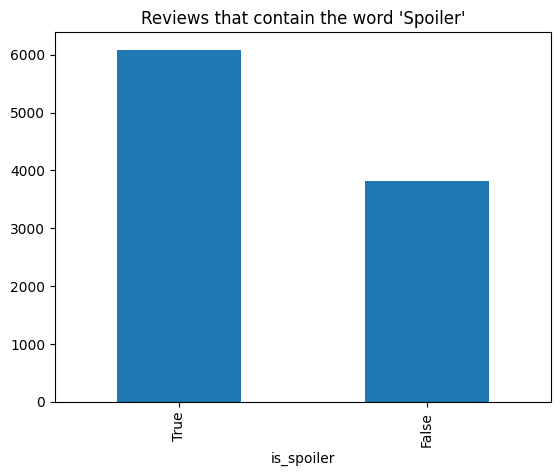

In [ ]:
#Checking reviews that contain the word 'Spoiler'
plt.title("Reviews that contain the word 'Spoiler'")
review_by_word(df, 'spoiler')

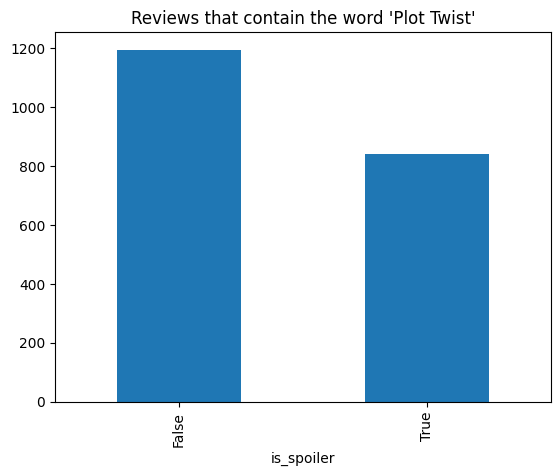

In [ ]:
#Checking reviews that contain the word 'Plot Twist'
plt.title("Reviews that contain the word 'Plot Twist'")
review_by_word(df, 'plot twist')

Building and Training the Neural Network

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#Picking out equal samples from the dataset to ensure there is no bias.

true_samples = df[df['is_spoiler'] == True].sample(n=30000)
false_samples = df[df['is_spoiler'] == False].sample(n=30000)
df_balanced = pd.concat([true_samples, false_samples])
X = df_balanced['cleaned_review_stemmed']
y = df_balanced['is_spoiler']

In [ ]:
#Preparing data to feed into the neural network.
lst = X.tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lst)
sequences = tokenizer.texts_to_sequences(lst)

In [ ]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
y = y.astype(int)

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, stratify=y)

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=max_length),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

In [ ]:
#Performance on Training Set
yTrainProbs = model.predict(X_train)
yTrainHat = (yTrainProbs>0.5)

1500/1500 [==============================] - 236s 157ms/step


Accuracy Score: 0.9016041666666667


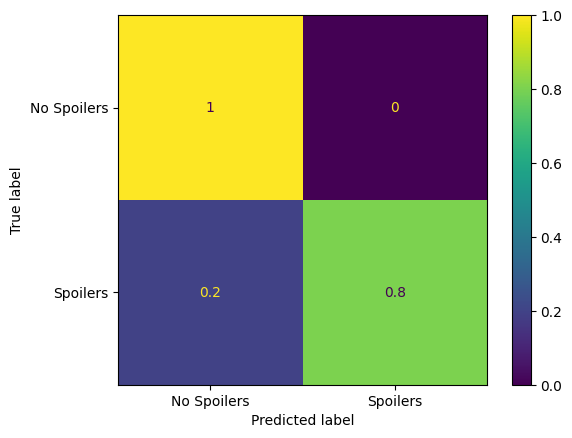

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
print("Accuracy Score:", accuracy_score(y_train, yTrainHat))
cm = confusion_matrix(y_train,yTrainHat,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                              ['No Spoilers','Spoilers'])
disp.plot()

In [ ]:
#Performance on Test Set
yTestProbs = model.predict(X_test)
yTestHat = (yTestProbs>0.5)

375/375 [==============================] - 65s 174ms/step


Accuracy Score: 0.85525


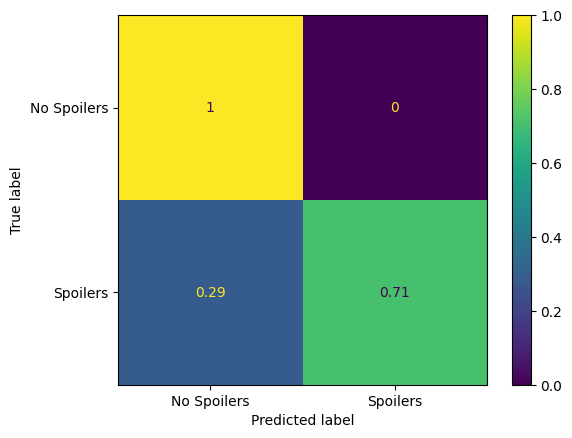

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
print("Accuracy Score:", accuracy_score(y_test, yTestHat))
cm = confusion_matrix(y_test,yTestHat,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                              ['No Spoilers','Spoilers'])
disp.plot()